### White Paper:
https://arxiv.org/pdf/2305.04091

Core idea:

1) Receive user request
2) Come up with a multi-step plan.
3) Generate task-list for the plan
4) Execute tasks by single task agents (This is a loop to solve tasks)
5) Update the state with task results
6) Re-plan more tasks
7) Go through that plan one item at a time. 

After accomplishing a particular task, you can then revisit the plan and modify as appropriate.

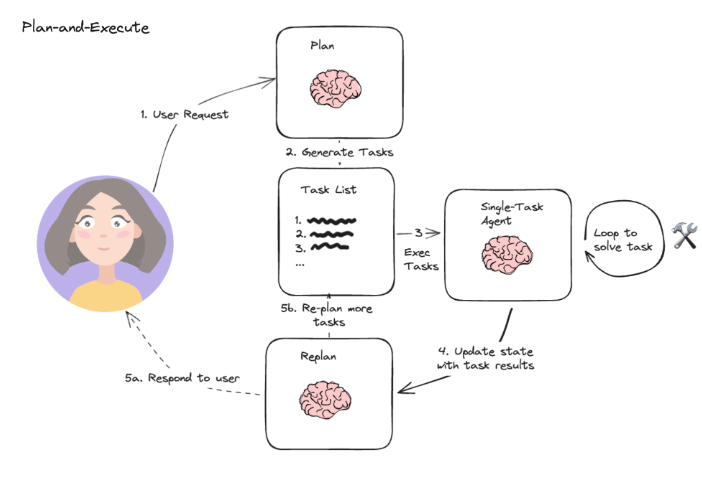

#### The advantages of this "plan-and-execute" style agent are:

1. Explicit long term planning (which even really strong LLMs can struggle with)
2. Ability to use smaller/weaker models for the execution step, only using larger/better models for the planning step

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="Plan-and-Execute"

## Define Tools

We will first define the tools we want to use. For this simple example, we will use a built-in search tool via Tavily. However, it is really easy to create your own tools - see documentation here on how to do that.
https://python.langchain.com/v0.2/docs/how_to/custom_tools/

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

### Define our Execution Agent

Now we will create the execution agent we want to use to execute tasks. 


In [3]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


c:\Code\Github\LangGraph\LangGraph\venv\lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(
C:\Users\neural_ninja\AppData\Local\Temp\ipykernel_29384\2020055812.py:12: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)


In [4]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})

{'messages': [HumanMessage(content='who is the winnner of the us open', id='dfdb54a7-f0b1-4063-a072-9746f4125234'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Og5UctexCr4iaaVts16l5YJX', 'function': {'arguments': '{"query":"US Open 2023 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 95, 'total_tokens': 118, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-52d6fc0f-31be-4dc5-ac37-5eba64c1c3b6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US Open 2023 winner'}, 'id': 'call_Og5UctexCr4iaaVts16l5YJX', 'type': 'tool_call'}], usage_metadata={'input_tokens': 95, 'output_tokens': 23, 'total_tokens': 118}),
  ToolMessage(content='[{"url

# Define the State
Let's now start by defining the state the track for this agent.

1) First, we will need to track the current plan. Let's represent that as a list of strings.
2) Next, we should track previously executed steps. Let's represent that as a list of tuples (these tuples will contain the step and then the result)
3) Finally, we need to have some state to represent the final response as well as the original input.


In [5]:
import operator
from typing import Annotated, List, Tuple, TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

# Planning Step
Let's now think about creating the planning step. This will use function calling to create a plan.




In [6]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [7]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan)

In [8]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current Australian Open winner for the most recent tournament.', 'Research the hometown of the identified winner.'])

# Re-Plan Step

Now, let's create a step that re-does the plan based on the result of the previous step.



In [9]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Act)

# Create the Graph
We can now create the graph!


In [10]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [15]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

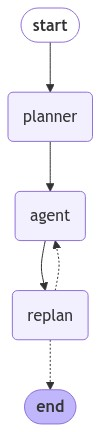

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [17]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identify the 2024 Australian Open winner once the tournament concludes.', "Research the winner's biography or profile to find their hometown.", 'Confirm the hometown information from reliable sources.']}
{'past_steps': [('Identify the 2024 Australian Open winner once the tournament concludes.', "The winner of the 2024 Australian Open Men's Singles is Jannik Sinner. He defeated Daniil Medvedev in the final with a score of 3-6, 3-6, 6-4, 6-4, 6-3, marking his first Grand Slam title.")]}
{'plan': ["Research Jannik Sinner's biography or profile to find his hometown.", 'Confirm the hometown information from reliable sources.']}
{'past_steps': [("Research Jannik Sinner's biography or profile to find his hometown.", 'Jannik Sinner was born in San Candido, Italy, on August 16, 2001. This information is confirmed by multiple sources, including Britannica and various sports biographies. \n\nWould you like me to proceed with step 2 and confirm this hometown information from reliable so